In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import math
import random
import timeit

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Linear Regression (Jan, Tim)

### 1. Import data and visualize what we have so far

In [2]:
marburg = pd.read_pickle("../0_data/marburg_clean.pkl")
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
marburg_weather = pd.read_pickle("../0_data/weather/marburg_weather.pkl")
duisburg_weather = pd.read_pickle("../0_data/weather/duisburg_weather.pkl")

In [3]:
marburg_weather["h"]= marburg_weather.index
marburg["h"]=marburg.index.floor(freq='h')
marburgWeather = pd.merge(marburg, marburg_weather, how='left', left_on='h', right_on='h')

*cool graph here*

### 2. Define independent and dependent variables

In [4]:
ym = marburgWeather.resample('H', on="h").count()["day"].values
xm = marburgWeather.resample('H', on="h").max()['temperature'].values.reshape(-1,1)
xm = np.nan_to_num(xm, nan = 10.511236338797794)

In [6]:
#xm_sum = np.sum(xm_no_nan)
#xm_nullcheck = np.isnan(xm_sum)
#xm_nullcheck

### 3. Train / Test split

In [5]:
xm_train, xm_test, ym_train, ym_test = train_test_split(xm, ym, test_size=0.2, random_state=0)

### 3. Initialize linear model with scikit-learn

In [6]:
linear_model_mar = LinearRegression()

### 4. Fit the model

In [7]:
linear_model_mar.fit(xm_train,ym_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### 5. Predict training data

In [8]:
y_pred_m = linear_model_mar.predict(xm_test)

### 6. Define y true

In [9]:
y_true_m = ym_test

### 7. Plot the linear model

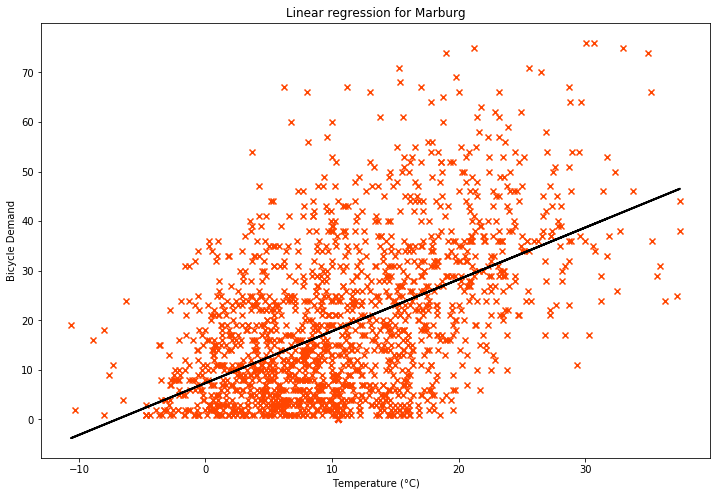

In [10]:
plt.figure(figsize = (12,8))

plt.scatter(xm_test, ym_test, marker="x", color = 'orangered')
plt.xlabel("Temperature (°C)")
plt.ylabel("Bicycle Demand")
plt.title("Linear regression for Marburg")

plt.plot(xm_test, y_pred_m, color = 'black', linewidth = 2, label='hier kommt noch ein label hin')

xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.xlim(xlim)
plt.ylim(ylim)
#plt.legend()
plt.show()

### 8. Present test metrics

In [11]:
#print("Mean Absolute Error:",mean_absolute_error(y_pred_m, y_true_m),"Einheit (glaube KM dann)")
#print("Root Mean Squared Error:",mean_squared_error(y_pred_m, y_true_m)**0.5,"Einheit")
#print("Coefficient of determination:",r2_score(y_pred_m, y_true_m))

print("Mean Absolute Error Marburg:",mean_absolute_error(y_true_m, y_pred_m),"Bicycles")
print("Root Mean Squared Error Marburg:",mean_squared_error(y_true_m, y_pred_m)**0.5,"Bicycles")
print("Coefficient of determination Marburg:",r2_score(y_true_m, y_pred_m))

Mean Absolute Error Marburg: 10.81111649215055 Bicycles
Root Mean Squared Error Marburg: 13.622387446003072 Bicycles
Coefficient of determination Marburg: 0.25051982715386956


### Linear regression for duisburg

In [12]:
duisburg_weather["h"]= duisburg_weather.index
duisburg["h"]=duisburg.index.floor(freq='h')
duisburgWeather = pd.merge(duisburg, duisburg_weather, how='left', left_on='h', right_on='h')

yd = duisburgWeather.resample('H', on="h").count()["day"].values
# day of year
xd = duisburgWeather.resample('H', on="h").max()['temperature'].values.reshape(-1,1)
xd = np.nan_to_num(xm, nan = 10.511236338797794)

xd_train, xd_test, yd_train, yd_test = train_test_split(xd, yd, test_size=0.2, random_state=0)

linear_model_dui = LinearRegression()

linear_model_dui.fit(xd_train,yd_train)

y_pred_d = linear_model_dui.predict(xd_test)

y_true_d = yd_test

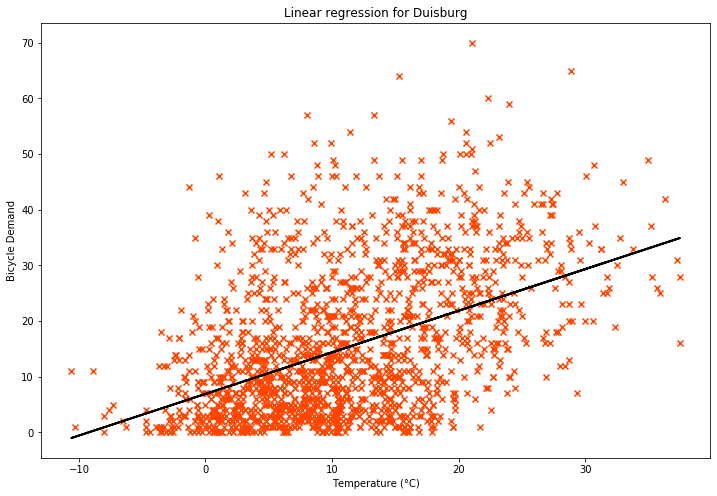

In [13]:
plt.figure(figsize = (12,8))

plt.scatter(xd_test, yd_test, marker="x", color = 'orangered')
plt.xlabel("Temperature (°C)")
plt.ylabel("Bicycle Demand")
plt.title("Linear regression for Duisburg")

plt.plot(xd_test, y_pred_d, color = 'black', linewidth = 2, label='hier kommt noch ein label hin')

xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.xlim(xlim)
plt.ylim(ylim)
#plt.legend()
plt.show()

In [14]:
print("Mean Absolute Error Duisburg:",mean_absolute_error(y_true_d, y_pred_d),"Bicycles")
print("Root Mean Squared Error Duisburg:",mean_squared_error(y_true_d, y_pred_d)**0.5,"Bicycles")
print("Coefficient of determination Duisburg:",r2_score(y_true_d, y_pred_d))

Mean Absolute Error Duisburg: 9.278303795484264 Bicycles
Root Mean Squared Error Duisburg: 11.698969700470746 Bicycles
Coefficient of determination Duisburg: 0.1971033950873139


## Multiple linear regression

Here we are adding another feature to our linear regression to see if it iproves the performance of our model.

In [15]:
def weekday_check (dt):
    day_count = dt.weekday()
    if day_count <=4:
        return 1
    else:
        return 0

marburgWeather["IsWeekday"] = marburgWeather["day"].apply(weekday_check)
marburgWeather

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,h,temperature,precipitation,IsWeekday
0,2019-07-04,13:29:00,11070,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3,13,41,2019-07-04 13:00:00,23.8,0.0,1
1,2019-07-06,16:53:00,11070,marburg,"(50.7987, 8.753)","(50.8058, 8.7828)",5,16,19,2019-07-06 16:00:00,28.1,0.0,0
2,2019-07-06,17:18:00,11070,marburg,"(50.8058, 8.7828)","(50.8229, 8.7747)",5,17,61,2019-07-06 17:00:00,27.7,0.0,0
3,2019-07-06,20:11:00,11070,marburg,"(50.82, 8.7737)","(50.7856, 8.7794)",5,20,30,2019-07-06 20:00:00,21.0,0.0,0
4,2019-07-07,08:47:00,11070,marburg,"(50.7856, 8.7794)","(50.7952, 8.7633)",6,8,12,2019-07-07 08:00:00,16.4,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164052,2019-05-19,12:57:00,91116,marburg,"(50.8279, 8.7751)","(50.8137, 8.7707)",6,12,20,2019-05-19 12:00:00,24.0,0.0,0
164053,2019-05-19,21:41:00,91116,marburg,"(50.8137, 8.7707)","(50.8229, 8.7747)",6,21,7,2019-05-19 21:00:00,12.5,0.0,0
164054,2019-05-20,06:56:00,91116,marburg,"(50.8229, 8.7747)","(50.82, 8.7737)",0,6,3,2019-05-20 06:00:00,13.5,0.0,1
164055,2019-05-20,07:32:00,91116,marburg,"(50.82, 8.7737)","(50.8185, 8.7737)",0,7,20,2019-05-20 07:00:00,14.9,0.0,1


In [16]:
MulRegMar = pd.DataFrame()
MulRegMar["temperature"] = marburgWeather.resample('H', on="h").max()['temperature'].values#.reshape(-1,1)
MulRegMar["temperature"] = MulRegMar["temperature"].fillna(10.511236338797794)
#MulRegMar["temperature"] = np.nan_to_num(xm, nan = 10.511236338797794)
MulRegMar["IsWeekday"] = marburgWeather.resample('H', on="h").max()["IsWeekday"].values
MulRegMar["IsWeekday"] = MulRegMar["IsWeekday"].fillna(1)
#MulRegMar["IsWeekday"] = np.nan_to_num(xm2, nan = 1)
MulRegMar["Demand"] = marburgWeather.resample('H', on="h").count()["day"].values
MulRegMar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  8784 non-null   float64
 1   IsWeekday    8784 non-null   float64
 2   Demand       8784 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 206.0 KB


In [17]:
Xm2 = MulRegMar[["temperature", "IsWeekday"]]
ym2 = MulRegMar[["Demand", "IsWeekday"]]
xm2_train, xm2_test, ym2_train, ym2_test = train_test_split(Xm2, ym2, test_size=0.2, random_state=0)
lin_mod_mul_m = LinearRegression()
lin_mod_mul_m.fit(xm2_train, ym2_train["Demand"])
y_pred_m2 = lin_mod_mul_m.predict(xm2_test)
y_true_m2 = ym2_test["Demand"]
print(lin_mod_mul_m.coef_, lin_mod_mul_m.intercept_)

[1.05000852 5.1346734 ] 3.5753900437280954


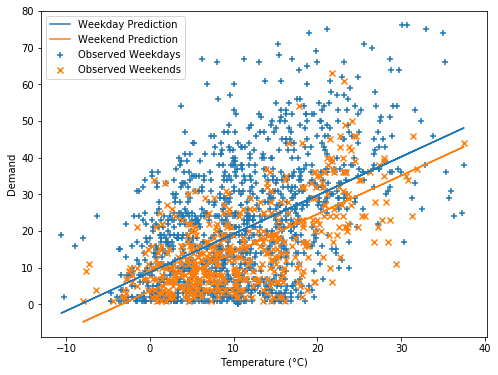

In [18]:
Xm2_weekday = xm2_test[xm2_test["IsWeekday"]==1]
Xm2_weekend = xm2_test[xm2_test["IsWeekday"]==0]
ym2_weekday = ym2_test[ym2_test["IsWeekday"]==1]
ym2_weekend = ym2_test[ym2_test["IsWeekday"]==0]
ym2_pred_weekday = lin_mod_mul_m.predict(Xm2_weekday)
ym2_pred_weekend = lin_mod_mul_m.predict(Xm2_weekend)

plt.figure(figsize = (8,6))

plt.scatter(Xm2_weekday["temperature"], ym2_weekday["Demand"],
            #MulRegMar[MulRegMar["IsWeekday"]==1]["Demand"], 
            marker="+", label="Observed Weekdays")

plt.scatter(Xm2_weekend["temperature"], ym2_weekend["Demand"],
            #MulRegMar[MulRegMar["IsWeekday"]==0]["Demand"], 
            marker="x", label="Observed Weekends")

plt.plot(Xm2_weekday["temperature"], 
         ym2_pred_weekday, 
         label="Weekday Prediction")
plt.plot(Xm2_weekend["temperature"], 
         ym2_pred_weekend, 
         label="Weekend Prediction")

plt.xlabel("Temperature (°C)")
plt.ylabel("Demand")

plt.legend()
plt.show()

Test metrics for one-dimensional vs. two-dimensional linear regression for Marburg:

In [19]:
#X_2md = MulRegMar[["temperature", "IsWeekday"]]
#y_pred_m2 = lin_mod_mul_m.predict(xm2_test)
print("MAE 1D Marburg:",mean_absolute_error(y_true_m, y_pred_m),"Bicycles")
print("MAE 2D Marburg:",mean_absolute_error(y_true_m2, y_pred_m2),"Bicycles")


print("RMSE 1D Marburg:",mean_squared_error(y_true_m, y_pred_m)**0.5,"Bicycles")
print("RMSE 2D Marburg:",mean_squared_error(y_true_m2, y_pred_m2)**0.5,"Bicycles")

print("R^2 1D Marburg:",r2_score(y_true_m, y_pred_m))
print("R^2 2D Marburg:",r2_score(y_true_m2, y_pred_m2))

MAE 1D Marburg: 10.81111649215055 Bicycles
MAE 2D Marburg: 10.70463924314468 Bicycles
RMSE 1D Marburg: 13.622387446003072 Bicycles
RMSE 2D Marburg: 13.490443469923742 Bicycles
R^2 1D Marburg: 0.25051982715386956
R^2 2D Marburg: 0.26496817286618013


### Multiple linear regression for Duisburg

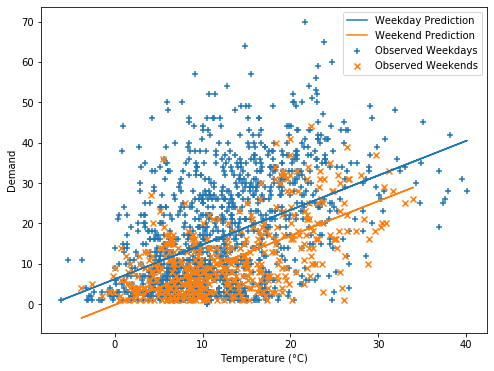

In [20]:
duisburgWeather["IsWeekday"] = duisburgWeather["day"].apply(weekday_check)
MulRegDui = pd.DataFrame()
MulRegDui["temperature"] = duisburgWeather.resample('H', on="h").max()['temperature'].values#.reshape(-1,1)
MulRegDui["temperature"] = MulRegDui["temperature"].fillna(10.511236338797794) #HIER NOCH AVG TEMP FÜR DUISBURG HIN!!!!!
MulRegDui["IsWeekday"] = duisburgWeather.resample('H', on="h").max()["IsWeekday"].values
MulRegDui["IsWeekday"] = MulRegDui["IsWeekday"].fillna(1)
MulRegDui["Demand"] = duisburgWeather.resample('H', on="h").count()["day"].values
Xd2 = MulRegDui[["temperature", "IsWeekday"]]
yd2 = MulRegDui[["Demand", "IsWeekday"]]
xd2_train, xd2_test, yd2_train, yd2_test = train_test_split(Xd2, yd2, test_size=0.2, random_state=0)
lin_mod_mul_d = LinearRegression()
lin_mod_mul_d.fit(xd2_train, yd2_train["Demand"])
y_pred_d2 = lin_mod_mul_d.predict(xd2_test)
y_true_d2 = yd2_test["Demand"]
Xd2_weekday = xd2_test[xd2_test["IsWeekday"]==1]
Xd2_weekend = xd2_test[xd2_test["IsWeekday"]==0]
yd2_weekday = yd2_test[yd2_test["IsWeekday"]==1]
yd2_weekend = yd2_test[yd2_test["IsWeekday"]==0]
yd2_pred_weekday = lin_mod_mul_d.predict(Xd2_weekday)
yd2_pred_weekend = lin_mod_mul_d.predict(Xd2_weekend)

plt.figure(figsize = (8,6))

plt.scatter(Xd2_weekday["temperature"], yd2_weekday["Demand"],
            #MulRegDui[MulRegDui["IsWeekday"]==1]["Demand"], 
            marker="+", label="Observed Weekdays")

plt.scatter(Xd2_weekend["temperature"], yd2_weekend["Demand"], 
            #MulRegDui[MulRegDui["IsWeekday"]==0]["Demand"], 
            marker="x", label="Observed Weekends")

plt.plot(Xd2_weekday["temperature"], 
         yd2_pred_weekday, 
         label="Weekday Prediction")
plt.plot(Xd2_weekend["temperature"], 
         yd2_pred_weekend, 
         label="Weekend Prediction")

plt.xlabel("Temperature (°C)")
plt.ylabel("Demand")

plt.legend()
plt.show()

Test metrics for one-dimensional vs. two-dimensional linear regression for Duisburg:

In [21]:
#y_true_d2 = MulRegDui["Demand"]
#X_2dd = MulRegDui[["temperature", "IsWeekday"]]
#y_pred_d2 = lin_mod_mul_d.predict(X_2dd)
print("MAE 1D Duisburg:",mean_absolute_error(y_true_d, y_pred_d),"Bicycles")
print("MAE 2D Duisburg:",mean_absolute_error(y_true_d2, y_pred_d2),"Bicycles")


print("RMSE 1D Duisburg:",mean_squared_error(y_true_d, y_pred_d)**0.5,"Bicycles")
print("RMSE 2D Duisburg:",mean_squared_error(y_true_d2, y_pred_d2)**0.5,"Bicycles")

print("R^2 1D Duisburg:",r2_score(y_true_d, y_pred_d))
print("R^2 2D Duisburg:",r2_score(y_true_d2, y_pred_d2))

MAE 1D Duisburg: 9.278303795484264 Bicycles
MAE 2D Duisburg: 8.936115931921169 Bicycles
RMSE 1D Duisburg: 11.698969700470746 Bicycles
RMSE 2D Duisburg: 11.329152534362557 Bicycles
R^2 1D Duisburg: 0.1971033950873139
R^2 2D Duisburg: 0.24706196309869222
